# <font color='red'>Tutorial on Good and Bad Controls</font>

In [8]:
import pandas as pd
import numpy as np
import random
import math
import sklearn
import scipy as sp
import networkx
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import sympy
# import dowhy as dw
from causalgraphicalmodels import CausalGraphicalModel


ImportError: cannot import name 'Iterable' from 'collections' (C:\Users\Roberto\anaconda3\envs\env_geopandas\lib\collections\__init__.py)

## <font color='blue'>Models 1, 2 and 3 - Good Controls (blocking back-door paths)</font>

### Model 1

In this model, the variable Z acts as a confounder of X and Y. In this regard, if we want to estimate the effects of X on Y that are not caused by changes in Z, we **must** control for Z. In this short example we introduce this reasoning in a Directed Acyclical Graph.

In [9]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","Y"),
                                        ("Z","X"),
                                        ("X","Y")])
sprinkler.draw()

NameError: name 'CausalGraphicalModel' is not defined

In [4]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
Z = np.random.normal(0,1, 1000).reshape((1000, 1))  # generate Z, the distribution of the variables do not really matter
X = 0.5*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 2*Z + np.random.normal(0, 1, 1000).reshape((1000, 1)) #Real effect is 3.

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [5]:
# Regressions
no_control = "Y ~ X"          #Wrong, not controlling by the confounder Z
using_control = "Y ~ X + Z"   # Correct

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0739    -0.0039  
               (0.0644)  (0.0323) 
R-squared      0.4718    0.8671   
R-squared Adj. 0.4712    0.8669   
X              1.7449*** 1.0088***
               (0.0584)  (0.0323) 
Z                        1.9841***
                         (0.0364) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


We can see that, although the real marginal effect of X on Y is 1, if we do not control for Z, we get a biased estimator, due to a spurious correlation.

### Model 2

Now let's think of a similar case, but this time the *confounder* is a non-observable variable. Nevertheless, controlling for Z blocks the backdoor path from this unobservable to X, leading to a unbiased estimator for the marginal effect of X on Y.

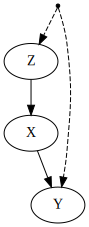

In [6]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","X"),
                                        ("X","Y")],
                                 latent_edges=[("Z","Y")])
sprinkler.draw()

In [7]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 2*U + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 0.5*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 2*U + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((U, Z, X, Y))
data = pd.DataFrame(D, columns = ["U", "Z", "X", "Y"])

In [8]:
# Regressions
no_control = "Y ~ X"           #Wrong, not controlling for confounder
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0657    0.0373   
               (0.0585)  (0.0436) 
R-squared      0.6784    0.8219   
R-squared Adj. 0.6781    0.8216   
X              1.8074*** 0.9281***
               (0.0394)  (0.0427) 
Z                        0.8279***
                         (0.0292) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


We can see that, although the real marginal effect of X on Y is 1, if we do not control for Z, we get a biased estimator, due to a spurious correlation.

### Model 3

A final example of a good control is presented in the figure below. Here, as before, we have an unobservable confounder, which affects both X and Z. In this case, although Z does not have an influence on X,controlling for Z would block the backdoor path from the unobserved to Z and Y.

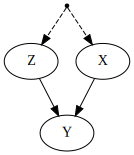

In [9]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","Y"),
                                        ("X","Y")],
                                 latent_edges=[("Z","X")])
sprinkler.draw()

In [10]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 2*U + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 0.5*U + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 2*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((U, Z, X, Y))
data = pd.DataFrame(D, columns = ["U", "Z", "X", "Y"])

In [11]:
# Regressions
no_control = "Y ~ X"           #Wrong, not controlling for confounder
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.1107    0.0076   
               (0.1312)  (0.0315) 
R-squared      0.3014    0.9597   
R-squared Adj. 0.3007    0.9596   
X              2.4169*** 0.9525***
               (0.1165)  (0.0303) 
Z                        2.0029***
                         (0.0157) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


We can see that, although the real marginal effect of X on Y is 1, if we do not control for Z, we get a biased estimator, due to a spurious correlation.

## <font color='blue'>Models 4, 5 and 6 - Good Controls (blocking back-door paths)</font>

Variables that have an effect on X, or any other mediatior (M) will act as a confounder of the effect of X on Y. Hence, to block this backdoor path, we must include them, in order to get an unbiased estimate.

### Model 4

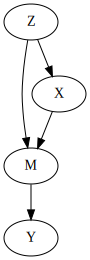

In [12]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","M","X"],
                                 edges=[("Z","M"),
                                        ("Z","X"),
                                        ("X","M"),
                                        ("M","Y")]
                                )
sprinkler.draw()

In [13]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
Z = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 0.5*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
M = 1.5*Z + 0.5*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 2*M + np.random.normal(0, 1, 1000).reshape((1000, 1)) #Efecto marginal de X en Y es 2.

# Create dataframe
D = np.hstack((Z, X, M, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "M", "Y"])

In [14]:
# Regressions
no_control = "Y ~ X"           #Wrong, not controlling for confounder
using_control = "Y ~ X + Z"      #classical
using_m = "Y ~ X + Z + M"      #Wrong, adding M will yield the direct effect of M on Y,but we are interested in the effect of X. 

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()
using_m = smf.ols(using_m,data=data).fit() 

# Summary results
dfoutput = summary_col([no_control,using_control,using_m],stars=True)
print(dfoutput)


                  Y I       Y II     Y III  
--------------------------------------------
Intercept      0.1157    -0.0021   0.0055   
               (0.1097)  (0.0702)  (0.0315) 
M                                  1.9401***
                                   (0.0309) 
R-squared      0.3044    0.7158    0.9428   
R-squared Adj. 0.3037    0.7152    0.9426   
X              2.0805*** 0.9661*** -0.0210  
               (0.0995)  (0.0701)  (0.0352) 
Z                        3.0039*** 0.1246** 
                         (0.0791)  (0.0580) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Model 5

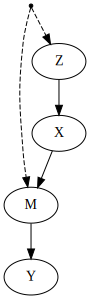

In [15]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","M","X"],
                                 edges=[("Z","X"),
                                        ("X","M"),
                                        ("M","Y")],
                                 latent_edges=[("Z","M")]
                                )
sprinkler.draw()

In [16]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(123456)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 2*U + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 0.5*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
M = 1.5*U + 0.5*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 2*M + np.random.normal(0, 1, 1000).reshape((1000, 1)) #Efecto marginal de X en Y es 2.

# Create dataframe
D = np.hstack((U, Z, X, M, Y))
data = pd.DataFrame(D, columns = ["U","Z", "X", "M", "Y"])

In [17]:
# Regressions
no_control = "Y ~ X"           #Wrong, not controlling for confounder
using_control = "Y ~ X + Z"      #classical
using_m = "Y ~ X + Z + M"      #Wrong, adding M will yield the direct effect of M on Y,but we are interested in the effect of X. 

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()
using_m = smf.ols(using_m,data=data).fit() 

# Summary results
dfoutput = summary_col([no_control,using_control,using_m],stars=True)
print(dfoutput)


                  Y I       Y II     Y III  
--------------------------------------------
Intercept      -0.0537   -0.0092   -0.0235  
               (0.0989)  (0.0814)  (0.0311) 
M                                  1.9635***
                                   (0.0257) 
R-squared      0.5721    0.7104    0.9578   
R-squared Adj. 0.5716    0.7098    0.9577   
X              2.3556*** 1.0333*** 0.0182   
               (0.0645)  (0.0805)  (0.0335) 
Z                        1.1562*** 0.0174   
                         (0.0530)  (0.0251) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


The real marginal effect of X on Y is 1. Including Z on the regression will block the backdoor path from X to Y due to the unobservable U. Besides, including the mediator M  will be wrong, as we try to estimate the ACE of X on Y.

### Model 6

As in the other models, controlling for Z will block the backdoor path from U to Y, produncing an unbiased estimator of the marginal effect of X on Y.

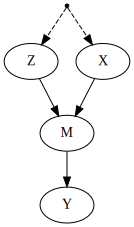

In [3]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","M","X"],
                                 edges=[("Z","M"),
                                        ("X","M"),
                                        ("M","Y")],
                                 latent_edges=[("X","Z")]
                                )
sprinkler.draw()

In [19]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(123456)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 2*U + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 0.5*U + np.random.normal(0, 1, 1000).reshape((1000, 1))
M = 1.5*Z + 0.5*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 2*M + np.random.normal(0, 1, 1000).reshape((1000, 1)) #Efecto marginal de X en Y es 2.

# Create dataframe
D = np.hstack((U, Z, X, M, Y))
data = pd.DataFrame(D, columns = ["U","Z", "X", "M", "Y"])

In [20]:
# Regressions
no_control = "Y ~ X"           #Wrong, not controlling for confounder
using_control = "Y ~ X + Z"      #classical
using_m = "Y ~ X + Z + M"      #Wrong, adding M will yield the direct effect of M on Y,but we are interested in the effect of X. 

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()
using_m = smf.ols(using_m,data=data).fit() 

# Summary results
dfoutput = summary_col([no_control,using_control,using_m],stars=True)
print(dfoutput)


                  Y I       Y II     Y III  
--------------------------------------------
Intercept      -0.1546   0.0332    -0.0226  
               (0.2119)  (0.0702)  (0.0311) 
M                                  1.9587***
                                   (0.0307) 
R-squared      0.2545    0.9184    0.9840   
R-squared Adj. 0.2537    0.9183    0.9839   
X              3.4382*** 0.9892*** 0.0165   
               (0.1863)  (0.0674)  (0.0335) 
Z                        2.9616*** 0.0579   
                         (0.0329)  (0.0477) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


The real marginal effect of X on Y is 1. Including Z on the regression will block the backdoor path from Z to Y due to the unobservable U. Besides, including the mediator M  will be wrong, as we try to estimate the ACE of X on Y.

## <font color='blue'>Model 7 - Bad Control (M-bias)</font>

### Case 1

Now consider the following DAC. We should observe that Z is correlated with X,Y , as it shares common unobservable confounders. Besides, Z is a pre-treatment variable. Nevertheless, including Z in the regression of X on Y would induce bias by opening the backdoor path $ X \leftarrow U1 \rightarrow Z \leftarrow U2 \rightarrow Y$ 

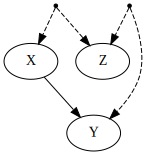

In [21]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Y")],
                                 latent_edges=[("X","Z"),("Z","Y")]
                                )
sprinkler.draw()

In [22]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(12345676)     # set MC seed

n = 1000                # sample size
U_1 = np.random.normal(0, 1, 1000).reshape((1000, 1))
U_2 = np.random.normal(0, 1, 1000).reshape((1000, 1))

Z = 0.5*U_1 + 0.5*U_2 + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 2*U_1 + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 2*U_2 + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((U_1,U_2, Z, X, Y))
data = pd.DataFrame(D, columns = ["U_1", "U_2", "Z", "X", "Y"])

In [23]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0238    0.0124   
               (0.0705)  (0.0645) 
R-squared      0.5196    0.5986   
R-squared Adj. 0.5191    0.5978   
X              1.0315*** 0.8690***
               (0.0314)  (0.0310) 
Z                        0.7654***
                         (0.0546) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Case 2. Controlling or not for Z is equally bad

Similarly, now consider the following DAC. We should observe that Z is correlated with X,Y , as it shares common unobservable confounders. Besides, Z is a pre-treatment variable, and now has a direct effect on Y. While including Z in the regression of X on Y now closes the backdoor path formed by $ X\leftarrow U1 \rightarrow Z \rightarrow Y$, it opens the other backdoor path formed by $ X \leftarrow U1 \rightarrow Z \leftarrow U2 \rightarrow Y$ . In neither case we would get a unbiased estimator.

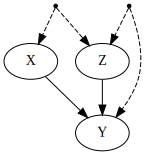

In [24]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Y"),("Z","Y")],
                                 latent_edges=[("X","Z"),("Z","Y")]
                                )
sprinkler.draw()

In [25]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(12345676)     # set MC seed

n = 1000                # sample size
U_1 = np.random.normal(0, 1, 1000).reshape((1000, 1))
U_2 = np.random.normal(0, 1, 1000).reshape((1000, 1))

Z = 0.5*U_1 + 0.5*U_2 + np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 2*U_2 + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 2*U_1 + 2*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((U_1,U_2, Z, X, Y))
data = pd.DataFrame(D, columns = ["U_1", "U_2", "Z", "X", "Y"])

In [26]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.2723**  0.1436** 
               (0.1203)  (0.0641) 
R-squared      0.4331    0.8393   
R-squared Adj. 0.4325    0.8390   
X              1.5003*** 0.8921***
               (0.0543)  (0.0314) 
Z                        2.7404***
                         (0.0546) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## <font color='blue'>Model 8 - Neutral Control (possibly good for precision)</font>

Here, Z is not a confounder nor a collider. Hence, if we want to estimate the marginal effect of X on Y using a regression of the form "Y ~ X", our estimator would be unbiased. However, studies show (Hahn 2004, White and Lu 2011, Henckel et al. 2019) that including Z helps to improve the precision of the ACE estimator (reduce variance).

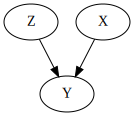

In [27]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","Y"),("X","Y")])
sprinkler.draw()

In [28]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(12345676)     # set MC seed

n = 1000                # sample size

Z = np.random.normal(0, 1, 1000).reshape((1000, 1))
X = np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 2*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [29]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.1404**  0.0001   
               (0.0713)  (0.0327) 
R-squared      0.1950    0.8312   
R-squared Adj. 0.1942    0.8309   
X              1.1088*** 1.0192***
               (0.0713)  (0.0327) 
Z                        2.0158***
                         (0.0329) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## <font color='blue'>Model 9 - Neutral Control (possibly bad for precision)</font>

As in model 8, Z is a neutral control, in the sense that including it or not does not affect the bias/unbiasedness of the marginal effect of X. However, controlling for Z will indeed reduce precision in the estimation of this parameter.

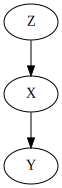

In [30]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","X"),("X","Y")])
sprinkler.draw()

In [31]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(12345676)     # set MC seed

n = 1000                # sample size

Z = np.random.normal(0, 1, 1000).reshape((1000, 1))
X = 2*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [32]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      -0.0002   0.0001   
               (0.0327)  (0.0327) 
R-squared      0.8312    0.8312   
R-squared Adj. 0.8311    0.8309   
X              1.0103*** 1.0192***
               (0.0144)  (0.0327) 
Z                        -0.0226  
                         (0.0745) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


As we can see, Model I, which only includes X as the regressor, has a lower standard deviation on the coefficient for X.

## <font color='blue'>Model 10 - Bad Control (bias amplification)</font>

In this model, although Z is a pre-treatment variable, controlling for it would confound the effect of X on Y, due to the phenomenon called "bias amplification".

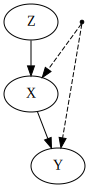

In [33]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("Z","X"),("X","Y")],
                                 latent_edges=[("X","Y")])
sprinkler.draw()

In [34]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(12345676)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
X = 0.5*Z + 2*U + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 3*U + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((U, Z, X, Y))
data = pd.DataFrame(D, columns = ["U", "Z", "X", "Y"])

In [35]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II   
-----------------------------------
Intercept      0.0028    -0.0095   
               (0.0569)  (0.0538)  
R-squared      0.8835    0.8960    
R-squared Adj. 0.8833    0.8958    
X              2.1183*** 2.1866*** 
               (0.0244)  (0.0238)  
Z                        -0.6111***
                         (0.0556)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


We can notice that Model II amplifies the existing bias, produced because we are lefting open the backdoor path $X \leftarrow U \rightarrow Y$.

## <font color='blue'>Models 11 and 12 - Bad Controls (overcontrol bias)</font>

### Model 11

This model looks similar to model 9, the difference being on that here Z is **affected by** X, and not viceversa. Hence, to estimate the effect of X on Y, it won't be neccesary to include Z. In fact, conditioning on Z will block the effect we want to estimate.

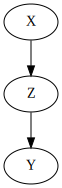

In [36]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Z"),("Z","Y")])
sprinkler.draw()

In [37]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate Z
Z = 0.5*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 2*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [38]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      -0.0368   -0.0039  
               (0.0714)  (0.0323) 
R-squared      0.1403    0.8239   
R-squared Adj. 0.1395    0.8236   
X              0.9325*** -0.0159  
               (0.0731)  (0.0364) 
Z                        2.0088***
                         (0.0323) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Including the mediator Z on the regression would not only be unnecessary, but will also bias the causal effect of X on Y.

### Model 12

Similar to model 11, although Z is not a mediator between X and Y, controlling for it is equivalent to partially controlling for M, hence incurring in the "overcontrol bias".

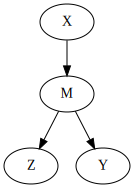

In [39]:
sprinkler = CausalGraphicalModel(nodes=["M","Z","Y","X"],
                                 edges=[("X","M"),("M","Z"),("M","Y")])
sprinkler.draw()

In [40]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate X
M = 4*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 0.5*M + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 0.25*M + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((M,Z, X, Y))
data = pd.DataFrame(D, columns = ["M","Z", "X", "Y"])

In [41]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0025    0.0029   
               (0.0322)  (0.0322) 
R-squared      0.4828    0.4834   
R-squared Adj. 0.4823    0.4823   
X              1.0044*** 0.9455***
               (0.0329)  (0.0646) 
Z                        0.0298   
                         (0.0282) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Including Z will bias our estimation of the effect of X on Y due to the overcontrol bias.

## <font color='blue'>Model 13 - Neutral Control (probably good for precision)</font>

Consider a somewhat similar model as before, the difference being now that z **affects** M, and not viceversa. As Z is not a confounder nor a collider, its inclusion can only affect variance. In fact, as in model 8, the inclusion of Z will help to improve the precision of the ACE estimator.

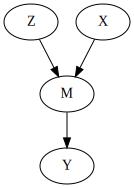

In [42]:
sprinkler = CausalGraphicalModel(nodes=["M","Z","Y","X"],
                                 edges=[("X","M"),("Z","M"),("M","Y")])
sprinkler.draw()

In [43]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate X
Z = np.random.normal(0, 1, 1000).reshape((1000, 1))
M = 2*X + 3*Z + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = 0.5*M + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((M,Z, X, Y))
data = pd.DataFrame(D, columns = ["M","Z", "X", "Y"])

In [44]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      -0.0200   0.0038   
               (0.0576)  (0.0346) 
R-squared      0.2115    0.7161   
R-squared Adj. 0.2107    0.7155   
X              0.9636*** 1.0041***
               (0.0589)  (0.0354) 
Z                        1.4529***
                         (0.0345) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


And this example proves it.

## <font color='blue'>Models 14 and 15 - Neutral Control (probably helpful in the case of selection bias)</font>

### Model 14

Now notice that controlling for Z won't open any backdoor path between X and Y, hence Z is neutral in terms of increasing bias. However, controlling for Z does reduce the variation of X, and will therefore reduce precision in the estimation of the causal effect of X on Y.

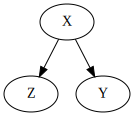

In [45]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Z"),("X","Y")])
sprinkler.draw()

In [46]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate X
Z = 2*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [47]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      -0.0041   -0.0039  
               (0.0323)  (0.0323) 
R-squared      0.4723    0.4723   
R-squared Adj. 0.4718    0.4713   
X              0.9883*** 0.9710***
               (0.0331)  (0.0718) 
Z                        0.0088   
                         (0.0323) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


We can see that including the covariate Z does affect the variability of X, hence amplifying variance in model II.

### Model 15

Now consider a variation of Model 14. In this case, Z is still nor a collider or confounder of X on Y, hence being neutral on bias. However, we have a colliding path on W, and by controlling for Z we can block it.

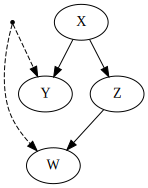

In [48]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X","W"],
                                 edges=[("X","Z"),("Z","W"),("X","Y")],
                                 latent_edges=[("W","Y")])
sprinkler.draw()

In [66]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(1234567)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate U
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate X
Z = 2*X + np.random.normal(0, 1, 1000).reshape((1000, 1))
W = Z + 2*U  + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + U + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y, W , U))
data = pd.DataFrame(D, columns = ["Z", "X", "Y","W","U"])

In [67]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0182    0.0182   
               (0.0438)  (0.0438) 
R-squared      0.3250    0.3250   
R-squared Adj. 0.3244    0.3237   
X              0.9591*** 0.9483***
               (0.0437)  (0.0967) 
Z                        0.0054   
                         (0.0429) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


We can see that including the covariate Z does affect the variability of X, hence amplifying variance in model II.

## <font color='blue'>Models 16 and 17 - Bad Controls (selection bias)</font>

In models 16 and 17, notice that Z acts as a collider (it is affected or caused by the treatment and the unobservable, and does not affect any variable). Hence, inclusion of Z would bias the estimation of the effect of X on Y.

### Model 16

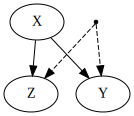

In [51]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Z"),("X","Y")],
                                 latent_edges=[("Z","Y")])
sprinkler.draw()

In [52]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(123456)     # set MC seed

n = 1000                # sample size
U = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate U
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate X
Z = 2*X + U + np.random.normal(0, 1, 1000).reshape((1000, 1))
Y = X + 1.5*U + np.random.normal(0, 1, 1000).reshape((1000, 1))

# Create dataframe
D = np.hstack((Z, X, Y, U))
data = pd.DataFrame(D, columns = ["Z", "X", "Y","U"])

In [53]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II   
-----------------------------------
Intercept      -0.0394   -0.0080   
               (0.0579)  (0.0464)  
R-squared      0.2374    0.5102    
R-squared Adj. 0.2367    0.5092    
X              1.0203*** -0.4771***
               (0.0579)  (0.0787)  
Z                        0.7527*** 
                         (0.0319)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Model 17

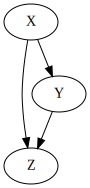

In [54]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Z"),("X","Y"),("Y","Z")],
                                 )
sprinkler.draw()

In [55]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(123456)     # set MC seed

n = 1000                # sample size
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate X
Y = X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 2*X + 0.5*Y + np.random.normal(0, 1, 1000).reshape((1000, 1))


# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [56]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0139    0.0097   
               (0.0317)  (0.0287) 
R-squared      0.5302    0.6137   
R-squared Adj. 0.5297    0.6129   
X              1.0179*** 0.0677   
               (0.0303)  (0.0703) 
Z                        0.3786***
                         (0.0258) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## <font color='blue'>Model 18 - Bad Controls (case-control bias)</font>

In this model, Z is not a mediator (it isn't somewhere in the middle of the pathway from X to Y), it is not a collider either, since it is not a direct cause of X. Nevertheless, including Z would bias the estimation of the causal effect of X on Y, because is a **descendant of a collider**. 

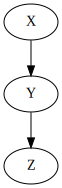

In [57]:
sprinkler = CausalGraphicalModel(nodes=["Z","Y","X"],
                                 edges=[("X","Y"),("Y","Z")],
                                 )
sprinkler.draw()

In [58]:
# Set Seed
# to make the results replicable (generating random numbers)
np.random.seed(123456)     # set MC seed

n = 1000                # sample size
X = np.random.normal(0, 1, 1000).reshape((1000, 1)) # generate X
Y = X + np.random.normal(0, 1, 1000).reshape((1000, 1))
Z = 3*Y + np.random.normal(0, 1, 1000).reshape((1000, 1))


# Create dataframe
D = np.hstack((Z, X, Y))
data = pd.DataFrame(D, columns = ["Z", "X", "Y"])

In [59]:
# Regressions
no_control = "Y ~ X"          
using_control = "Y ~ X + Z"      #classical

no_control = smf.ols(no_control , data=data).fit()
using_control = smf.ols(using_control , data=data).fit()

# Summary results
dfoutput = summary_col([no_control,using_control],stars=True)
print(dfoutput)


                  Y I       Y II  
----------------------------------
Intercept      0.0139    0.0001   
               (0.0317)  (0.0102) 
R-squared      0.5302    0.9513   
R-squared Adj. 0.5297    0.9512   
X              1.0179*** 0.0960***
               (0.0303)  (0.0139) 
Z                        0.3018***
                         (0.0033) 
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
